In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import dataframe_image as dfi

In [2]:
"""
Loads in raw score file
Expecting the schema 
Name	Date	GF	GA	Team

Calcuates result, margies and goal difference
Does some prep work for Form and Win

Obviously names need to be consistant
"""
season = "S4_results"

raw_data = pd.read_csv("../data/"+season+".csv")
raw_data["GD"] = raw_data["GF"] - raw_data["GA"]
raw_data.loc[(raw_data['GD'] == 0), 'GamePoints'] = 0.5
raw_data.loc[(raw_data['GD'] < 0), 'GamePoints'] = -1
raw_data.loc[(raw_data['GD'] > 0), 'GamePoints'] = 1
raw_data.loc[(raw_data['GD'] > 6), 'GamePoints'] = 1.5
raw_data.loc[(raw_data['GD'] < -6), 'GamePoints'] = -1.5
raw_data.loc[(raw_data['GamePoints'] >= 1), 'W'] = 1
raw_data.loc[(raw_data['GamePoints'] == 0.5), 'D'] = 1
raw_data.loc[(raw_data['GamePoints'] <= -1), 'L'] = 1
raw_data.loc[(raw_data['GamePoints'] == 1.5), 'MW'] = 1
raw_data.loc[(raw_data['GamePoints'] == -1.5), 'ML'] = 1

raw_data.loc[(raw_data['GamePoints'] >= 1), 'Result'] = '🔼'
raw_data.loc[(raw_data['GamePoints'] == 0.5), 'Result'] = '➖'
raw_data.loc[(raw_data['GamePoints'] <= -1), 'Result'] = '🔽'
raw_data.loc[(raw_data['GamePoints'] == 1.5), 'Result'] = '⏫'
raw_data.loc[(raw_data['GamePoints'] == -1.5), 'Result'] = '⏬'

raw_data = raw_data[raw_data["Name"].str.contains("\*")==False] # Removes Ringers

raw_data = raw_data.fillna(0)
pd.set_option('display.float_format', '{:.1f}'.format)
raw_data = raw_data.astype({'W':'int','D':'int','L':'int','MW':'int','ML':'int','GF':'int','GA':'int','GD':'int'})

raw_data['Date'] = pd.to_datetime(raw_data['Date'],dayfirst = True)
gameweek_int = raw_data.nunique().Date
gameweek = "Gameweek " + str(gameweek_int)

dates = pd.DataFrame(raw_data.sort_values("Date").Date.unique(),columns=['Date'])
dates['Gameweek'] = dates.index+1

raw_data = raw_data.merge(dates,how='right',on='Date')

pd.set_option('display.max_rows', 50)

display(raw_data)

,Name,Date,GF,GA,Team,GD,GamePoints,W,D,L,MW,ML,Result,Gameweek
0,Calz,2025-05-22,13,10,Whites,3,1.0,1,0,0,0,0,🔼,1
1,Camilla,2025-05-22,13,10,Whites,3,1.0,1,0,0,0,0,🔼,1
2,Keysey,2025-05-22,13,10,Whites,3,1.0,1,0,0,0,0,🔼,1
3,Novak,2025-05-22,13,10,Whites,3,1.0,1,0,0,0,0,🔼,1
4,Venus Williams,2025-05-22,13,10,Whites,3,1.0,1,0,0,0,0,🔼,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,JD Wetherspoon,2025-08-30,5,6,Colours,-1,-1.0,0,0,1,0,0,🔽,17
151,Venus Williams,2025-08-30,5,6,Colours,-1,-1.0,0,0,1,0,0,🔽,17
152,Schurrle,2025-08-30,5,6,Colours,-1,-1.0,0,0,1,0,0,🔽,17
153,Helmet,2025-08-30,5,6,Colours,-1,-1.0,0,0,1,0,0,🔽,17


In [3]:
"""
Tracking week by week table position

"""
def get_gameweek(raw_data, Gameweek):

    gameweek_data = raw_data.loc[(raw_data['Gameweek']<=(Gameweek))].reset_index(drop=True)
    gameweek_data = get_totals(gameweek_data)
    table = gameweek_data.merge(form_column(raw_data),on='Name').rename(columns={"Result":"Form"})
    gameweek_column_name = "Week" +str(Gameweek)
    table[gameweek_column_name] = table.index + 1
    table.index = table.Name
    table = table[[gameweek_column_name]]
    return table

def plot_save_bumpchart(raw_data):

    ranked = get_gameweek(raw_data,1)

    for week in range(raw_data['Date'].nunique()-1):
        week = week+2
        ranked = ranked.merge(get_gameweek(raw_data,week),how='right',on='Name')
    ranked.to_csv("../outputs/bumpchart.csv")
    ranked.T.to_csv("../outputs/bumpchart_t.csv")

    plt.figure(figsize=(10,2))
    plt.plot(ranked.T, alpha=0.9, linewidth=6)
    plt.xticks(rotation=70)
    plt.ylim(16, 0)
    #plt.gca().invert_xaxis()
    #plt.xticks(rotation=70)    

    plt.gca().invert_xaxis()
    plt.gca().invert_xaxis()
    plt.show()
    return(ranked)
ranked = plot_save_bumpchart(raw_data)

#https://public.flourish.studio/visualisation/15712793/

NameError: name 'get_totals' is not defined

In [36]:
"""
Code from Github that creates a bumpchart 
""" 

def bumpchart(df, show_rank_axis= True, rank_axis_distance= 1.1, 
              ax= None, scatter= False, holes= False,
              line_args= {}, scatter_args= {}, hole_args= {}):
    
    if ax is None:
        left_yaxis= plt.gca()
    else:
        left_yaxis = ax

    # Creating the right axis.
    right_yaxis = left_yaxis.twinx()
    
    axes = [left_yaxis, right_yaxis]
    
    # Creating the far right axis if show_rank_axis is True
    if show_rank_axis:
        far_right_yaxis = left_yaxis.twinx()
        axes.append(far_right_yaxis)
    
    for col in df.columns:
        y = df[col]
        x = df.index.values
        # Plotting blank points on the right axis/axes 
        # so that they line up with the left axis.
        for axis in axes[1:]:
            axis.plot(x, y, alpha= 0)

        left_yaxis.plot(x, y, **line_args, solid_capstyle='round')
        
        # Adding scatter plots
        if scatter:
            left_yaxis.scatter(x, y, **scatter_args)
            
            #Adding see-through holes
            if holes:
                bg_color = left_yaxis.get_facecolor()
                left_yaxis.scatter(x, y, color= bg_color, **hole_args)

    # Number of lines
    lines = len(df.columns)

    y_ticks = [*range(1, lines + 1)]
    
    # Configuring the axes so that they line up well.
    for axis in axes:
        axis.invert_yaxis()
        axis.set_yticks(y_ticks)
        axis.set_ylim((lines + 0.5, 0.5))
    
    # Sorting the labels to match the ranks.
    left_labels = df.iloc[0].sort_values().index
    right_labels = df.iloc[-1].sort_values().index
    
    left_yaxis.set_yticklabels(left_labels)
    right_yaxis.set_yticklabels(right_labels)
    
    # Setting the position of the far right axis so that it doesn't overlap with the right axis
    if show_rank_axis:
        far_right_yaxis.spines["right"].set_position(("axes", rank_axis_distance))
    
    return axes

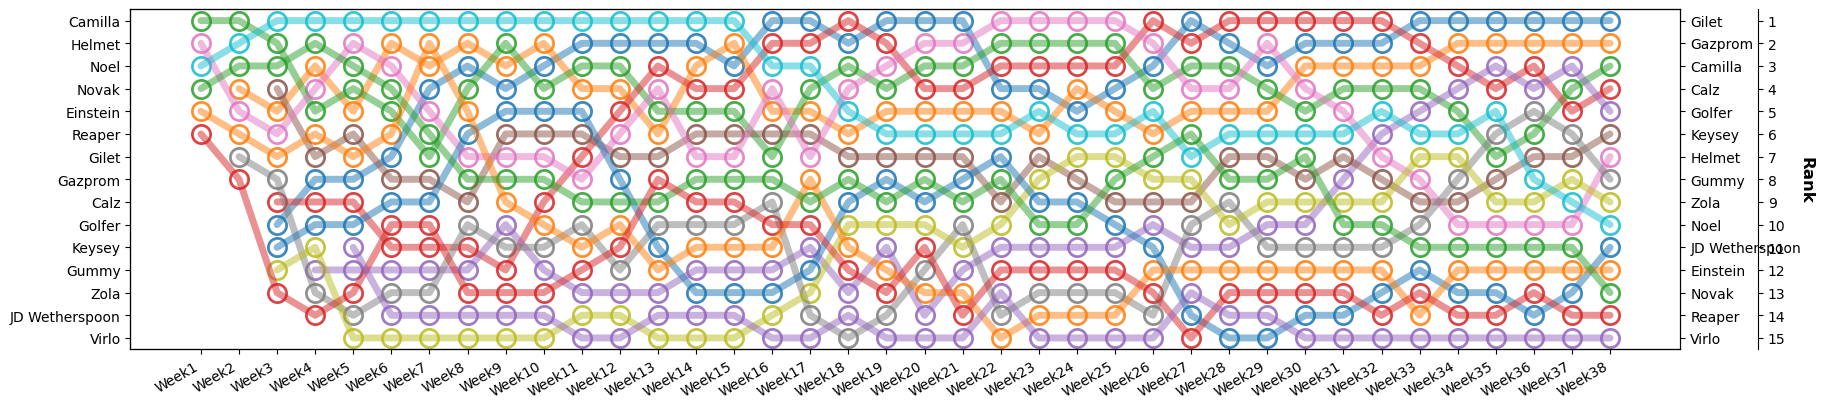

In [37]:
def bumpchart_external(ranked):

    plt.figure(figsize=(20, 5))

    [laxis, raxis, fraxis] = bumpchart(
                               ranked.T, show_rank_axis= True, 
                               rank_axis_distance= 1.05,
                               ax= None, 
                               scatter= True, 
                               holes= True,
                               line_args= {"linewidth": 5, "alpha": 0.5},
                               scatter_args= {"s": 200, "alpha": 0.8},
                               hole_args= {"s": 100, "alpha": 1})



    laxis.set_axisbelow(True)

    fraxis.set_ylabel("Rank", rotation= -90, labelpad= 20, fontsize= 12, weight= "semibold")\

    plt.gcf().autofmt_xdate()

    plt.show()
    
bumpchart_external(ranked)

## https://app.flourish.studio/%E2%80%A01320
